# Laplace Approximation for Time-Series Forecasting
Augment a deterministic forecaster with a Laplace posterior and visualise calibrated uncertainty bands.


## Tutorial Roadmap
We retrofit a trained multilayer perceptron with a diagonal Laplace approximation. Two contrasting scenarios highlight how data availability and noise level shape posterior predictive bounds:
1. **Scenario 1 - Limited Data & High Noise:** Few training samples and strong observation noise lead to wide uncertainty bands.
2. **Scenario 2 - Abundant Data & Low Noise:** Many clean observations drive the posterior to concentrate, yielding narrow bands.


In [57]:
# Configure Python path so the notebook sees the local deepuq package
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd())
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

SRC_PATH = str(PROJECT_ROOT / 'src')
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)


In [58]:
import importlib
import math
from typing import Dict, Iterable, Tuple

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from deepuq.models import MLP
from deepuq.utils import set_seed

import deepuq.methods.laplace as laplace_module
LaplaceWrapper = importlib.reload(laplace_module).LaplaceWrapper

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {DEVICE}')


Running on cuda


## Helper Utilities
The following helpers (1) synthesise noisy sinusoids, (2) reshape the series into windowed datasets, (3) train a deterministic baseline, and (4) fit/plot the Laplace posterior. Extensive comments document the workflow.


In [59]:
WINDOW_SIZE = 24  # number of past steps used as input
HORIZON = 1       # predict the next step
BATCH_SIZE = 128
HIDDEN_DIMS = [128, 64]
OUTPUT_DIM = 1

class WindowedTimeSeries(Dataset):
    '''Turn a 1D time-series into (window, target) pairs.'''
    def __init__(self, data: torch.Tensor, window_size: int, horizon: int = 1):
        self.data = data.float()
        self.window_size = window_size
        self.horizon = horizon

    def __len__(self) -> int:
        return len(self.data) - self.window_size - self.horizon + 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        window = self.data[idx : idx + self.window_size]
        target = self.data[idx + self.window_size + self.horizon - 1]
        return window, target.unsqueeze(0)

def generate_series(total_points: int, noise_scale: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''Create a multi-frequency sinusoid with configurable Gaussian noise.'''
    time_axis = torch.linspace(0, 12 * math.pi, total_points)
    clean_signal = (
        torch.sin(time_axis)
        + 0.5 * torch.sin(0.5 * time_axis)
        + 0.2 * torch.sin(3.0 * time_axis)
        + 0.01 * time_axis
    )
    noise = noise_scale * torch.randn_like(clean_signal)
    noisy_series = clean_signal + noise
    return time_axis, clean_signal, noisy_series

def create_dataloaders(series: torch.Tensor, train_points: int, window_size: int, horizon: int, batch_size: int) -> Tuple[DataLoader, DataLoader, torch.Tensor]:
    '''Split the series and wrap it with DataLoader objects.'''
    train_series = series[:train_points].clone()
    test_series = series[train_points - window_size :].clone()
    train_ds = WindowedTimeSeries(train_series, window_size, horizon)
    test_ds = WindowedTimeSeries(test_series, window_size, horizon)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, train_series

def train_model(model: nn.Module, train_loader: Iterable, epochs: int, device: torch.device) -> None:
    '''Simple training loop with periodic logging.'''
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=3e-3)
    model.train()
    log_every = max(epochs // 5, 1)
    for epoch in range(epochs):
        running_loss = 0.0
        for windows, targets in train_loader:
            windows = windows.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            preds = model(windows)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * windows.size(0)
        if (epoch + 1) % log_every == 0 or epoch == epochs - 1:
            avg_loss = running_loss / len(train_loader.dataset)
            print(f'Epoch {epoch+1:03d} | Train MSE: {avg_loss:.6f}')

def collect_deterministic_predictions(model: nn.Module, test_loader: Iterable, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    '''Return stacked test inputs, targets, and point predictions.'''
    model.eval()
    inputs, targets, preds = [], [], []
    with torch.no_grad():
        for windows, target in test_loader:
            windows = windows.to(device)
            prediction = model(windows).cpu()
            inputs.append(windows.cpu())
            targets.append(target)
            preds.append(prediction)
    test_inputs = torch.cat(inputs, dim=0)
    test_targets = torch.cat(targets, dim=0)
    deterministic_mean = torch.cat(preds, dim=0)
    mse = nn.functional.mse_loss(deterministic_mean, test_targets)
    return test_inputs, test_targets, mse

def fit_laplace(model: nn.Module, train_loader: Iterable, prior_precision: float, subset: str) -> LaplaceWrapper:
    '''Instantiate and train the diagonal Laplace posterior.'''
    laplace = LaplaceWrapper(model, likelihood='regression', subset_of_weights=subset)
    laplace.fit(train_loader, prior_precision=prior_precision)
    return laplace

def compute_intervals(mean: torch.Tensor, var: torch.Tensor, z: float = 1.96) -> Dict[str, torch.Tensor]:
    '''Return mean, std, and symmetric confidence bounds.'''
    mean = mean.squeeze(-1).cpu()
    std = torch.sqrt(var.squeeze(-1).cpu().clamp_min(1e-12))
    lower = mean - z * std
    upper = mean + z * std
    return {'mean': mean, 'std': std, 'lower': lower, 'upper': upper}

def plot_forecast(time_axis: torch.Tensor, train_points: int, test_targets: torch.Tensor, intervals: Dict[str, torch.Tensor], title: str, train_series: torch.Tensor) -> None:
    '''Overlay training data, ground truth, and Laplace posterior intervals.'''
    test_time_axis = time_axis[train_points : train_points + len(test_targets)]
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis[:train_points], train_series, label='Train observations', linewidth=1.0)
    plt.plot(test_time_axis, test_targets.squeeze(-1), label='Ground truth', linewidth=1.0, color='tab:green')
    plt.plot(test_time_axis, intervals['mean'], label='Laplace mean prediction', color='tab:orange', linewidth=1.2)
    plt.fill_between(test_time_axis, intervals['lower'], intervals['upper'], color='tab:orange', alpha=0.3, label='95% confidence')
    plt.title(title)
    plt.xlabel('Time index')
    plt.ylabel('Signal value')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

def run_scenario(config: Dict) -> Dict:
    '''End-to-end pipeline for a single uncertainty scenario.'''
    set_seed(config.get('seed', 21))
    total_points = config.get('total_points', 720)
    noise_scale = config['noise_scale']
    train_points = config['train_points']
    epochs = config.get('epochs', 200)
    prior_precision = config.get('prior_precision', 1.0)
    subset = config.get('subset_of_weights', 'last_layer')
    mc_samples = config.get('mc_samples', 200)

    time_axis, clean_signal, noisy_series = generate_series(total_points, noise_scale)
    train_loader, test_loader, train_series = create_dataloaders(noisy_series, train_points, WINDOW_SIZE, HORIZON, config.get('batch_size', BATCH_SIZE))

    model = MLP(input_dim=WINDOW_SIZE, hidden_dims=config.get('hidden_dims', HIDDEN_DIMS), output_dim=OUTPUT_DIM).to(DEVICE)
    train_model(model, train_loader, epochs, DEVICE)

    test_inputs, test_targets, mse = collect_deterministic_predictions(model, test_loader, DEVICE)
    laplace = fit_laplace(model, train_loader, prior_precision=prior_precision, subset=subset)
    predictive_mean, predictive_var = laplace.predict(test_inputs.to(DEVICE), n_samples=mc_samples)
    intervals = compute_intervals(predictive_mean, predictive_var)

    avg_band = (intervals['upper'] - intervals['lower']).mean().item()
    print(f"Scenario '{config['name']}' summary -> Test MSE: {mse.item():.5f}, Avg 95% width: {avg_band:.5f}")

    return {
        'config': config,
        'time_axis': time_axis,
        'train_points': train_points,
        'train_series': train_series,
        'test_targets': test_targets,
        'intervals': intervals,
        'mse': mse.detach(),
        'avg_band': avg_band,
    }


## Scenario Overview
Each scenario tweaks the noise level, number of training points, and Monte Carlo sample count to modulate predictive uncertainty.


### Scenario 1 - Limited Data & High Noise
- Only 360 training points.
- High observation noise (`noise_scale = 0.35`).
- More Monte Carlo samples (400) to better resolve broad uncertainty.
Expect wide Laplace intervals because both data scarcity and noise inflate posterior variance.


In [60]:
scenario_high_uncertainty = {
    'name': 'Scenario 1 - Limited Data & High Noise',
    'seed': 21,
    'noise_scale': 0.35,
    'train_points': 360,
    'epochs': 140,
    'prior_precision': 0.5,
    'mc_samples': 400,
}
results_high = run_scenario(scenario_high_uncertainty)


Epoch 028 | Train MSE: 0.102572
Epoch 056 | Train MSE: 0.037539
Epoch 084 | Train MSE: 0.013759
Epoch 112 | Train MSE: 0.004793
Epoch 140 | Train MSE: 0.001643
Scenario 'Scenario 1 - Limited Data & High Noise' summary -> Test MSE: 0.22976, Avg 95% width: 12.90237


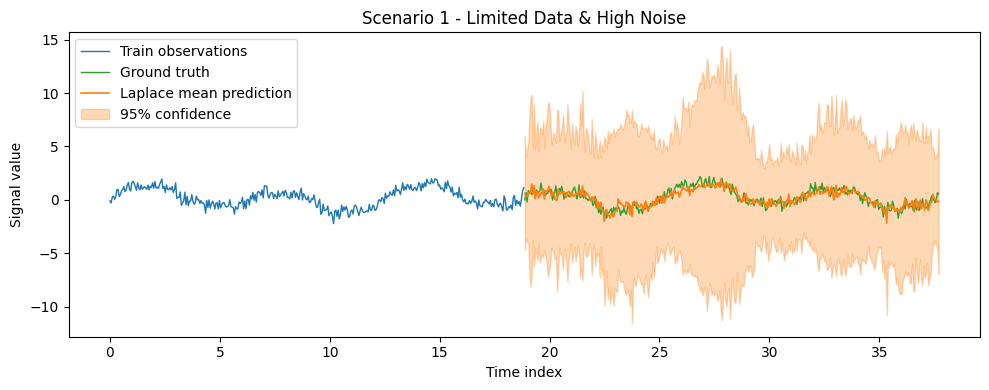

In [61]:
plot_forecast(
    results_high['time_axis'],
    results_high['train_points'],
    results_high['test_targets'],
    results_high['intervals'],
    title=results_high['config']['name'],
    train_series=results_high['train_series'],
)


The 95% interval balloons well beyond the ground-truth variation, signalling the model's limited certainty when confronted with noisy, scarce data.


### Scenario 2 - Abundant Data & Low Noise
- 640 training points expose the model to most of the time-series structure.
- Mild observation noise (`noise_scale = 0.05`).
- Fewer Monte Carlo samples (120) suffice because the posterior is concentrated.
Expect tight Laplace intervals that hug the ground-truth curve.


In [64]:
scenario_low_uncertainty = {
    'name': 'Scenario 2 - Abundant Data & Low Noise',
    'seed': 7,
    'noise_scale': 0.05,
    'train_points': 640,
    'epochs': 2000,
    'prior_precision': 5.0,
    'mc_samples': 120,
}
results_low = run_scenario(scenario_low_uncertainty)


Epoch 400 | Train MSE: 0.003122
Epoch 800 | Train MSE: 0.001863
Epoch 1200 | Train MSE: 0.000709
Epoch 1600 | Train MSE: 0.000469
Epoch 2000 | Train MSE: 0.000278
Scenario 'Scenario 2 - Abundant Data & Low Noise' summary -> Test MSE: 0.00649, Avg 95% width: 3.95434


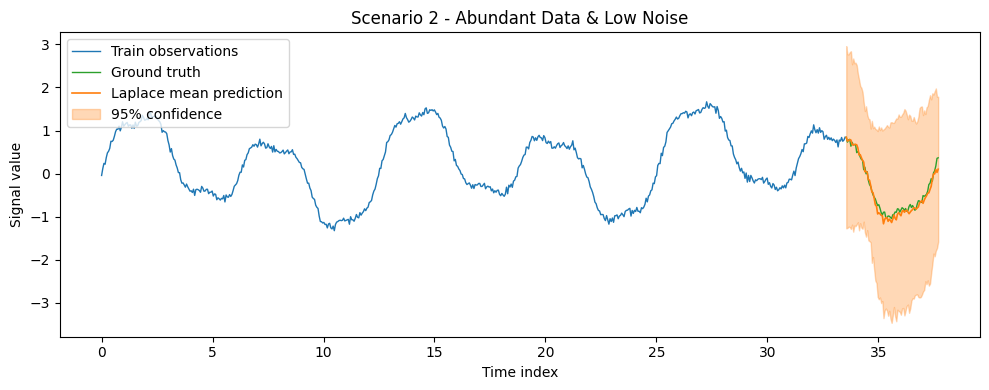

In [65]:
plot_forecast(
    results_low['time_axis'],
    results_low['train_points'],
    results_low['test_targets'],
    results_low['intervals'],
    title=results_low['config']['name'],
    train_series=results_low['train_series'],
)


As predicted, abundant, clean data yields narrow posterior intervals that closely track the underlying signal.


## Takeaways
- Posterior uncertainty responds gracefully to data quality: noisier, sparser data inflates variance, whereas cleaner, plentiful samples tighten it.
- `prior_precision` and the Monte Carlo sample count provide additional levers to tune predictive spread and smoothness.
- Try experimenting with different `subset_of_weights` settings or alternative network architectures for richer uncertainty behaviour.
